# Initialization

## Import

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
    
import torchvision.transforms.functional as tF

from utils.save_load_utils import save_model, load_model
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
from utils.evaluation_utils import calculate_miou, check_acc
                                                                     
import albumentations as A

%matplotlib inline
import os
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


## Hyperparameters

In [49]:
hyperparameters = {
    'test_dir' : './images/newTest',
    'train_dir' : './images/newTrain',
    'seed' : 9999,
    'dataloader' :{
        'batch_size' : 8,
        'num_workers' : 4,
        'pin_memory' : False, 
    },
    'optimizer' :{
        'lr' : 1e-4,
        'betas' : (0.9, 0.999),
        'weight_decay' : 1e-4,
    },
    'epochs' : 150,
    'training_size' : 0,
    'test_size': 0,
    'gradient_clipping' : 1.0,
    'vgg19': {
        'in_channels': 3,
        'out_channels': 1,
        'features': 64,
    }, 
    'pre_trained_path': 'checkpoints/pretrained/newBest.pth.tar',
    'checkpoints_dir': './checkpoints/daft/',
    'output_dir':{
        'results':'./generated_examples/',
        'model':'./generated_examples/daft/',
    },
}

## Seed Everything

In [50]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(hyperparameters['seed'])

# Data Preprocessing

## Data Augmentation

In [51]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

## Dataset

In [52]:
from dataset.dataset import seg_datasets

train_dataset = seg_datasets(hyperparameters['train_dir'], train_transforms)
test_dataset = seg_datasets(hyperparameters['test_dir'], test_transforms)

len(train_dataset), len(test_dataset)

(84, 21)

In [53]:
hyperparameters['training_size'] = len(train_dataset)
hyperparameters['test_size'] = len(test_dataset)

In [54]:
sample = train_dataset[30]
torch.unique(sample[1])

tensor([0., 1., 2., 3., 4.])

In [55]:
img, mask = train_dataset[20]
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


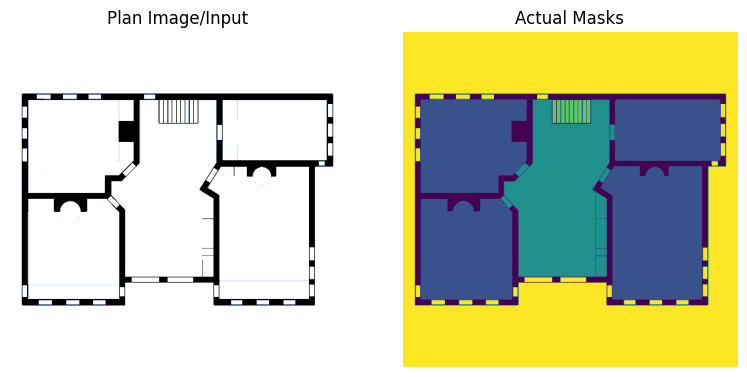

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('Plan Image/Input')
ax1.imshow(img.permute(1, 2, 0).numpy())
    
ax2.axis('off')
ax2.set_title('Actual Masks')
ax2.imshow(mask.numpy().transpose(1,2,0))

## Color Mapping

In [57]:
color_mapping = {
    0: (0, 0, 0),         # Walls
    1: (255, 80, 80),     # Iwan
    2: (80, 80, 255),     # Room
    3: (255, 255, 255),   # Background
    4: (255, 255, 0),     # Stairs
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

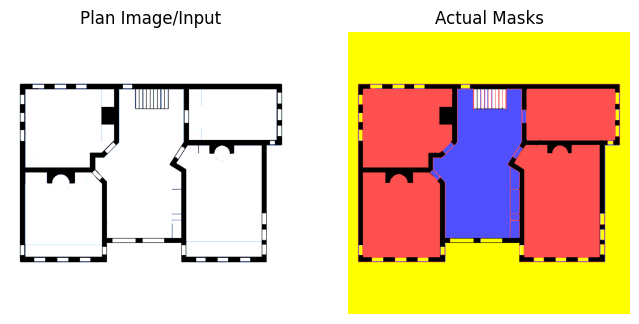

In [58]:
visualization = visualize_segmentation(mask, color_mapping, from_tensor=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(img.permute(1, 2, 0).numpy())
ax1.set_title('Plan Image/Input')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Actual Masks')
ax2.axis('off')

## Dataloader

In [59]:
from utils.dataloader_utils import get_loader

train_dataloader, test_dataloader = get_loader(
    train_dir = hyperparameters['train_dir'],
    test_dir = hyperparameters['test_dir'],
    batch_size = hyperparameters['dataloader']['batch_size'],
    train_transform = train_transforms,
    test_transform = test_transforms,
    num_workers = hyperparameters['dataloader']['num_workers'],
    pin_memory = hyperparameters['dataloader']['pin_memory']
)

len(train_dataloader), len(test_dataloader)

(11, 3)

In [60]:
img_a_batch, img_b_batch = next(iter(train_dataloader))
print(img_a_batch.shape, img_b_batch.shape)
print(img_a_batch.size(0))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])
8


# Model

## Model Loading

In [61]:
from models.vgg19 import VGGUNET19

model = VGGUNET19(
    features = hyperparameters['vgg19']['features'], 
    in_channels=hyperparameters['vgg19']['in_channels'], 
    out_channels=hyperparameters['vgg19']['out_channels']
)

In [62]:

checkpoint = torch.load(hyperparameters['pre_trained_path'])
model.load_state_dict(checkpoint['model_state_dict'], strict=True)

model.to(device)


C:\Users\sungur daştan\AppData\Local\Temp\ipykernel_12100\1320677305.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(hyperparameters['pre_trained

VGGUNET19(
  (inc): DoubleConv(
    (DoubleConv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (DoubleConv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-0

In [63]:

# Tüm katmanları serbest bırakmak yerine yalnızca son birkaç katmanı güncellemek için "requires_grad" ayarı yapılır.
for param in model.parameters():
    param.requires_grad = False

# Yeni veri bölgesine uyum sağlamak için encoder'ın en üst katmanları ve decoder katmanları açılır
for layer in [model.inc, model.down1, model.down2, model.up3, model.up4, model.out]:
    for param in layer.parameters():
        param.requires_grad = True


## Number of Parameters

In [64]:
### Dummy Data
__batch_size = 1
__in_channels = hyperparameters['vgg19']['in_channels']
__width = 512
__height = 512


dummy_input = torch.randn((__batch_size, __in_channels, __height, __width)).to(device)
dummy_out = model(dummy_input)

print(f'Model input size: {dummy_input.shape}')
print(f'Model output size: {dummy_out.shape}')


Model input size: torch.Size([1, 3, 512, 512])
Model output size: torch.Size([1, 1, 512, 512])


In [65]:
print(f'Number of Parameters: {sum(dummy_out.numel() for p in model.parameters()):,}')

Number of Parameters: 25,427,968


# Loss & Optimizer

## Loss Function

In [66]:
criterion = nn.MSELoss(reduction='none')

def loss_fn(pred, mask, alpha=0.01):
    
    loss_by_pixel = criterion(pred, mask)
    loss = loss_by_pixel.mean()
    
    return loss

## Optimizer & Scheduler

In [67]:
learning_rate = hyperparameters['optimizer']['lr']
betas = hyperparameters['optimizer']['betas']

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    betas = betas, 
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=40, factor=0.1)

# Training

## Train/Evaluation Function

In [68]:
from train_eval_func import train_fn, eval_fn

## Start Training

In [69]:
best_model = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

history = {
    'train_loss': [],
    'eval_loss' : [],
    'eval_miou' : [],
    'eval_acc' : [],
}

In [70]:
def train_start():
    model.to(device)
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            train_size = hyperparameters['training_size'], 
            model = model,
            dataloader = train_dataloader, 
            optimizer = optimizer, 
            criterion = loss_fn, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            test_size = hyperparameters['test_size'], 
            model = model, 
            dataloader = test_dataloader, 
            criterion = loss_fn, 
            device = device,
            color_mapping = color_mapping,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)
        history['eval_miou'].append(eval_miou)
        history['eval_acc'].append(eval_acc)
        
        save_model(
            model=model, 
            optimizer=optimizer, 
            root_folder=hyperparameters['checkpoints_dir'], 
            file_name='Daft_Segmentation_checkpoint1', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model['best_eval_miou']:
            best_model['best_state_dict'] = model.state_dict().copy()
            best_model['best_epoch'] = epoch
            best_model['best_eval_loss'] = eval_loss
            best_model['best_eval_miou'] = eval_miou
            best_model['best_eval_acc'] = eval_acc
            
            save_model(
                model=model, 
                optimizer=optimizer, 
                root_folder=hyperparameters['checkpoints_dir'], 
                file_name='Daft_Segmentation_best2', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model, 
                last_epoch=epoch, 
                verbose=True)
            
            save_model(
                model=model, 
                optimizer=optimizer, 
                root_folder='./checkpoints/unsupervised/', 
                file_name='UL_Segmentation3',
                hyperparameter_dict=hyperparameters, 
                best_model=best_model, 
                last_epoch=epoch, )
            
        scheduler.step(eval_loss)

## Model Training

In [71]:
train_start()

Eval/Epoch 1/150: 100%|██████████| 21/21 [00:03<00:00,  5.78img/s]


"
        Epoch: 1, 
        Average Train Loss: 0.1195 |
        Average Test Loss: 0.0797 |
        Average Test mIoU: 77.45
        Average Test Accuracy: 94.79377746582031
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 2/150: 100%|██████████| 21/21 [00:03<00:00,  5.98img/s]


"
        Epoch: 2, 
        Average Train Loss: 0.0819 |
        Average Test Loss: 0.0621 |
        Average Test mIoU: 81.24
        Average Test Accuracy: 96.74949645996094
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 3/150: 100%|██████████| 21/21 [00:03<00:00,  6.05img/s]


"
        Epoch: 3, 
        Average Train Loss: 0.0864 |
        Average Test Loss: 0.0710 |
        Average Test mIoU: 79.64
        Average Test Accuracy: 96.78604125976562


Eval/Epoch 4/150: 100%|██████████| 21/21 [00:03<00:00,  5.88img/s]


"
        Epoch: 4, 
        Average Train Loss: 0.0878 |
        Average Test Loss: 0.0661 |
        Average Test mIoU: 79.28
        Average Test Accuracy: 96.4019775390625


Eval/Epoch 5/150: 100%|██████████| 21/21 [00:03<00:00,  6.08img/s]


"
        Epoch: 5, 
        Average Train Loss: 0.0695 |
        Average Test Loss: 0.0549 |
        Average Test mIoU: 81.31
        Average Test Accuracy: 95.989990234375
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 6/150: 100%|██████████| 21/21 [00:03<00:00,  6.08img/s]


"
        Epoch: 6, 
        Average Train Loss: 0.0681 |
        Average Test Loss: 0.0577 |
        Average Test mIoU: 79.96
        Average Test Accuracy: 95.82901000976562


Eval/Epoch 7/150: 100%|██████████| 21/21 [00:03<00:00,  6.07img/s]


"
        Epoch: 7, 
        Average Train Loss: 0.0633 |
        Average Test Loss: 0.0517 |
        Average Test mIoU: 81.35
        Average Test Accuracy: 96.59873962402344
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 8/150: 100%|██████████| 21/21 [00:03<00:00,  6.10img/s]


"
        Epoch: 8, 
        Average Train Loss: 0.0671 |
        Average Test Loss: 0.0495 |
        Average Test mIoU: 81.88
        Average Test Accuracy: 96.53564453125
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 9/150: 100%|██████████| 21/21 [00:03<00:00,  6.04img/s]


"
        Epoch: 9, 
        Average Train Loss: 0.0682 |
        Average Test Loss: 0.0494 |
        Average Test mIoU: 82.75
        Average Test Accuracy: 96.57005310058594
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 10/150: 100%|██████████| 21/21 [00:03<00:00,  6.15img/s]


"
        Epoch: 10, 
        Average Train Loss: 0.0601 |
        Average Test Loss: 0.0458 |
        Average Test mIoU: 83.95
        Average Test Accuracy: 96.74125671386719
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 11/150: 100%|██████████| 21/21 [00:03<00:00,  6.23img/s]


"
        Epoch: 11, 
        Average Train Loss: 0.0642 |
        Average Test Loss: 0.0510 |
        Average Test mIoU: 82.69
        Average Test Accuracy: 96.94587707519531


Eval/Epoch 12/150: 100%|██████████| 21/21 [00:03<00:00,  6.24img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.0566 |
        Average Test Loss: 0.0592 |
        Average Test mIoU: 81.37
        Average Test Accuracy: 97.96371459960938


Eval/Epoch 13/150: 100%|██████████| 21/21 [00:03<00:00,  6.18img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.0555 |
        Average Test Loss: 0.0468 |
        Average Test mIoU: 82.65
        Average Test Accuracy: 97.16636657714844


Eval/Epoch 14/150: 100%|██████████| 21/21 [00:03<00:00,  6.32img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.0535 |
        Average Test Loss: 0.0458 |
        Average Test mIoU: 83.73
        Average Test Accuracy: 96.64497375488281


Eval/Epoch 15/150: 100%|██████████| 21/21 [00:03<00:00,  5.42img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.0562 |
        Average Test Loss: 0.0460 |
        Average Test mIoU: 82.78
        Average Test Accuracy: 97.59391784667969


Eval/Epoch 16/150: 100%|██████████| 21/21 [00:04<00:00,  4.91img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.0567 |
        Average Test Loss: 0.0433 |
        Average Test mIoU: 84.24
        Average Test Accuracy: 97.29751586914062
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 17/150: 100%|██████████| 21/21 [00:04<00:00,  4.89img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.0697 |
        Average Test Loss: 0.0484 |
        Average Test mIoU: 84.50
        Average Test Accuracy: 96.64337158203125
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 18/150: 100%|██████████| 21/21 [00:04<00:00,  4.81img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.0491 |
        Average Test Loss: 0.0451 |
        Average Test mIoU: 83.05
        Average Test Accuracy: 97.47718811035156


Eval/Epoch 19/150: 100%|██████████| 21/21 [00:04<00:00,  4.92img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.0503 |
        Average Test Loss: 0.0494 |
        Average Test mIoU: 83.37
        Average Test Accuracy: 97.46673583984375


Eval/Epoch 20/150: 100%|██████████| 21/21 [00:04<00:00,  4.63img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.0479 |
        Average Test Loss: 0.0478 |
        Average Test mIoU: 83.35
        Average Test Accuracy: 97.02461242675781


Eval/Epoch 21/150: 100%|██████████| 21/21 [00:04<00:00,  4.79img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.0483 |
        Average Test Loss: 0.0472 |
        Average Test mIoU: 83.36
        Average Test Accuracy: 96.72882080078125


Eval/Epoch 22/150: 100%|██████████| 21/21 [00:04<00:00,  4.77img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.0513 |
        Average Test Loss: 0.0434 |
        Average Test mIoU: 84.76
        Average Test Accuracy: 97.77198791503906
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 23/150: 100%|██████████| 21/21 [00:04<00:00,  4.90img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.0476 |
        Average Test Loss: 0.0471 |
        Average Test mIoU: 83.85
        Average Test Accuracy: 97.32460021972656


Eval/Epoch 24/150: 100%|██████████| 21/21 [00:04<00:00,  4.64img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.0474 |
        Average Test Loss: 0.0505 |
        Average Test mIoU: 83.96
        Average Test Accuracy: 96.78016662597656


Eval/Epoch 25/150: 100%|██████████| 21/21 [00:04<00:00,  4.77img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.0441 |
        Average Test Loss: 0.0431 |
        Average Test mIoU: 84.97
        Average Test Accuracy: 97.22915649414062
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 26/150: 100%|██████████| 21/21 [00:04<00:00,  4.82img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.0469 |
        Average Test Loss: 0.0501 |
        Average Test mIoU: 83.35
        Average Test Accuracy: 95.919189453125


Eval/Epoch 27/150: 100%|██████████| 21/21 [00:04<00:00,  4.82img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.0447 |
        Average Test Loss: 0.0462 |
        Average Test mIoU: 82.89
        Average Test Accuracy: 96.75308227539062


Eval/Epoch 28/150: 100%|██████████| 21/21 [00:04<00:00,  4.84img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.0455 |
        Average Test Loss: 0.0500 |
        Average Test mIoU: 82.44
        Average Test Accuracy: 98.06526184082031


Eval/Epoch 29/150: 100%|██████████| 21/21 [00:04<00:00,  4.75img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.0406 |
        Average Test Loss: 0.0437 |
        Average Test mIoU: 85.08
        Average Test Accuracy: 96.65946960449219
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 30/150: 100%|██████████| 21/21 [00:04<00:00,  4.75img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.0458 |
        Average Test Loss: 0.0635 |
        Average Test mIoU: 79.29
        Average Test Accuracy: 95.20118713378906


Eval/Epoch 31/150: 100%|██████████| 21/21 [00:04<00:00,  4.86img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.0482 |
        Average Test Loss: 0.0505 |
        Average Test mIoU: 82.32
        Average Test Accuracy: 96.14067077636719


Eval/Epoch 32/150: 100%|██████████| 21/21 [00:04<00:00,  4.91img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.0472 |
        Average Test Loss: 0.0545 |
        Average Test mIoU: 82.13
        Average Test Accuracy: 96.14036560058594


Eval/Epoch 33/150: 100%|██████████| 21/21 [00:04<00:00,  4.60img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.0490 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 84.11
        Average Test Accuracy: 97.00897216796875


Eval/Epoch 34/150: 100%|██████████| 21/21 [00:04<00:00,  4.86img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.0473 |
        Average Test Loss: 0.0416 |
        Average Test mIoU: 85.30
        Average Test Accuracy: 97.82020568847656
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 35/150: 100%|██████████| 21/21 [00:04<00:00,  4.79img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.0490 |
        Average Test Loss: 0.0547 |
        Average Test mIoU: 83.00
        Average Test Accuracy: 98.8189697265625


Eval/Epoch 36/150: 100%|██████████| 21/21 [00:04<00:00,  4.64img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.0430 |
        Average Test Loss: 0.0485 |
        Average Test mIoU: 83.31
        Average Test Accuracy: 98.08013916015625


Eval/Epoch 37/150: 100%|██████████| 21/21 [00:04<00:00,  4.70img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.0440 |
        Average Test Loss: 0.0466 |
        Average Test mIoU: 83.72
        Average Test Accuracy: 96.24053955078125


Eval/Epoch 38/150: 100%|██████████| 21/21 [00:04<00:00,  4.78img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.0463 |
        Average Test Loss: 0.0410 |
        Average Test mIoU: 84.78
        Average Test Accuracy: 97.65029907226562


Eval/Epoch 39/150: 100%|██████████| 21/21 [00:04<00:00,  4.69img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.0444 |
        Average Test Loss: 0.0454 |
        Average Test mIoU: 83.42
        Average Test Accuracy: 98.05831909179688


Eval/Epoch 40/150: 100%|██████████| 21/21 [00:04<00:00,  4.53img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.0423 |
        Average Test Loss: 0.0397 |
        Average Test mIoU: 85.44
        Average Test Accuracy: 97.87117004394531
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 41/150: 100%|██████████| 21/21 [00:04<00:00,  4.81img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.0427 |
        Average Test Loss: 0.0449 |
        Average Test mIoU: 84.75
        Average Test Accuracy: 98.78074645996094


Eval/Epoch 42/150: 100%|██████████| 21/21 [00:04<00:00,  4.74img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.0344 |
        Average Test Loss: 0.0424 |
        Average Test mIoU: 84.82
        Average Test Accuracy: 98.26271057128906


Eval/Epoch 43/150: 100%|██████████| 21/21 [00:04<00:00,  4.77img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.0436 |
        Average Test Loss: 0.0620 |
        Average Test mIoU: 80.03
        Average Test Accuracy: 95.27656555175781


Eval/Epoch 44/150: 100%|██████████| 21/21 [00:04<00:00,  4.66img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.0455 |
        Average Test Loss: 0.0608 |
        Average Test mIoU: 80.77
        Average Test Accuracy: 97.16598510742188


Eval/Epoch 45/150: 100%|██████████| 21/21 [00:04<00:00,  4.60img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.0452 |
        Average Test Loss: 0.0421 |
        Average Test mIoU: 84.78
        Average Test Accuracy: 96.6632080078125


Eval/Epoch 46/150: 100%|██████████| 21/21 [00:04<00:00,  4.56img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.0415 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.24
        Average Test Accuracy: 97.28981018066406


Eval/Epoch 47/150: 100%|██████████| 21/21 [00:04<00:00,  4.55img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.0435 |
        Average Test Loss: 0.0464 |
        Average Test mIoU: 84.25
        Average Test Accuracy: 98.16062927246094


Eval/Epoch 48/150: 100%|██████████| 21/21 [00:04<00:00,  4.82img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.0413 |
        Average Test Loss: 0.0473 |
        Average Test mIoU: 83.24
        Average Test Accuracy: 96.73171997070312


Eval/Epoch 49/150: 100%|██████████| 21/21 [00:04<00:00,  4.64img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.0387 |
        Average Test Loss: 0.0468 |
        Average Test mIoU: 84.01
        Average Test Accuracy: 96.51947021484375


Eval/Epoch 50/150: 100%|██████████| 21/21 [00:04<00:00,  4.86img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.0379 |
        Average Test Loss: 0.0423 |
        Average Test mIoU: 84.65
        Average Test Accuracy: 97.91496276855469


Eval/Epoch 51/150: 100%|██████████| 21/21 [00:04<00:00,  4.87img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.0329 |
        Average Test Loss: 0.0468 |
        Average Test mIoU: 84.09
        Average Test Accuracy: 98.01643371582031


Eval/Epoch 52/150: 100%|██████████| 21/21 [00:04<00:00,  4.86img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.0354 |
        Average Test Loss: 0.0439 |
        Average Test mIoU: 84.72
        Average Test Accuracy: 98.1878662109375


Eval/Epoch 53/150: 100%|██████████| 21/21 [00:04<00:00,  4.81img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.0375 |
        Average Test Loss: 0.0486 |
        Average Test mIoU: 83.72
        Average Test Accuracy: 97.18940734863281


Eval/Epoch 54/150: 100%|██████████| 21/21 [00:04<00:00,  4.92img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.0396 |
        Average Test Loss: 0.0440 |
        Average Test mIoU: 85.63
        Average Test Accuracy: 97.46978759765625
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 55/150: 100%|██████████| 21/21 [00:04<00:00,  4.57img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.0384 |
        Average Test Loss: 0.0420 |
        Average Test mIoU: 85.39
        Average Test Accuracy: 97.97187805175781


Eval/Epoch 56/150: 100%|██████████| 21/21 [00:04<00:00,  4.79img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0361 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 84.64
        Average Test Accuracy: 98.07861328125


Eval/Epoch 57/150: 100%|██████████| 21/21 [00:04<00:00,  4.64img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0379 |
        Average Test Loss: 0.0414 |
        Average Test mIoU: 86.18
        Average Test Accuracy: 98.2330322265625
Checkpoint: Daft_Segmentation_best2 is saved successfully


Eval/Epoch 58/150: 100%|██████████| 21/21 [00:04<00:00,  4.77img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0385 |
        Average Test Loss: 0.0435 |
        Average Test mIoU: 85.37
        Average Test Accuracy: 97.60795593261719


Eval/Epoch 59/150: 100%|██████████| 21/21 [00:04<00:00,  4.71img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0392 |
        Average Test Loss: 0.0411 |
        Average Test mIoU: 85.58
        Average Test Accuracy: 98.36990356445312


Eval/Epoch 60/150: 100%|██████████| 21/21 [00:04<00:00,  4.53img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0400 |
        Average Test Loss: 0.0524 |
        Average Test mIoU: 83.20
        Average Test Accuracy: 98.63967895507812


Eval/Epoch 61/150: 100%|██████████| 21/21 [00:04<00:00,  4.56img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0388 |
        Average Test Loss: 0.0637 |
        Average Test mIoU: 81.33
        Average Test Accuracy: 98.43177795410156


Eval/Epoch 62/150: 100%|██████████| 21/21 [00:04<00:00,  4.63img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0320 |
        Average Test Loss: 0.0455 |
        Average Test mIoU: 84.63
        Average Test Accuracy: 96.95808410644531


Eval/Epoch 63/150: 100%|██████████| 21/21 [00:04<00:00,  4.57img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0374 |
        Average Test Loss: 0.0478 |
        Average Test mIoU: 84.73
        Average Test Accuracy: 96.89910888671875


Eval/Epoch 64/150: 100%|██████████| 21/21 [00:04<00:00,  4.77img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0375 |
        Average Test Loss: 0.0443 |
        Average Test mIoU: 84.99
        Average Test Accuracy: 98.79539489746094


Eval/Epoch 65/150: 100%|██████████| 21/21 [00:04<00:00,  4.66img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0384 |
        Average Test Loss: 0.0430 |
        Average Test mIoU: 85.78
        Average Test Accuracy: 98.53271484375


Eval/Epoch 66/150: 100%|██████████| 21/21 [00:04<00:00,  4.80img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0344 |
        Average Test Loss: 0.0405 |
        Average Test mIoU: 85.85
        Average Test Accuracy: 98.37837219238281


Eval/Epoch 67/150: 100%|██████████| 21/21 [00:03<00:00,  5.32img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0345 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 85.29
        Average Test Accuracy: 97.40203857421875


Eval/Epoch 68/150: 100%|██████████| 21/21 [00:04<00:00,  5.17img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0322 |
        Average Test Loss: 0.0591 |
        Average Test mIoU: 82.29
        Average Test Accuracy: 95.48622131347656


Eval/Epoch 69/150: 100%|██████████| 21/21 [00:03<00:00,  5.40img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0332 |
        Average Test Loss: 0.0552 |
        Average Test mIoU: 83.02
        Average Test Accuracy: 98.79074096679688


Eval/Epoch 70/150: 100%|██████████| 21/21 [00:04<00:00,  5.09img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0340 |
        Average Test Loss: 0.0412 |
        Average Test mIoU: 85.52
        Average Test Accuracy: 98.193359375


Eval/Epoch 71/150: 100%|██████████| 21/21 [00:04<00:00,  5.05img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0344 |
        Average Test Loss: 0.0419 |
        Average Test mIoU: 85.66
        Average Test Accuracy: 97.29644775390625


Eval/Epoch 72/150: 100%|██████████| 21/21 [00:03<00:00,  6.19img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0395 |
        Average Test Loss: 0.0456 |
        Average Test mIoU: 84.89
        Average Test Accuracy: 98.7347412109375


Eval/Epoch 73/150: 100%|██████████| 21/21 [00:04<00:00,  4.91img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0414 |
        Average Test Loss: 0.0457 |
        Average Test mIoU: 84.44
        Average Test Accuracy: 97.86239624023438


Eval/Epoch 74/150: 100%|██████████| 21/21 [00:04<00:00,  5.23img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0339 |
        Average Test Loss: 0.0443 |
        Average Test mIoU: 85.22
        Average Test Accuracy: 97.76084899902344


Eval/Epoch 75/150: 100%|██████████| 21/21 [00:04<00:00,  5.05img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0387 |
        Average Test Loss: 0.0443 |
        Average Test mIoU: 84.34
        Average Test Accuracy: 98.36540222167969


Eval/Epoch 76/150: 100%|██████████| 21/21 [00:03<00:00,  5.37img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0398 |
        Average Test Loss: 0.0482 |
        Average Test mIoU: 84.76
        Average Test Accuracy: 98.17779541015625


Eval/Epoch 77/150: 100%|██████████| 21/21 [00:03<00:00,  5.97img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0354 |
        Average Test Loss: 0.0460 |
        Average Test mIoU: 84.96
        Average Test Accuracy: 97.99507141113281


Eval/Epoch 78/150: 100%|██████████| 21/21 [00:04<00:00,  5.10img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0365 |
        Average Test Loss: 0.0425 |
        Average Test mIoU: 86.04
        Average Test Accuracy: 98.311767578125


Eval/Epoch 79/150: 100%|██████████| 21/21 [00:03<00:00,  5.79img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0350 |
        Average Test Loss: 0.0457 |
        Average Test mIoU: 84.06
        Average Test Accuracy: 98.74969482421875


Eval/Epoch 80/150: 100%|██████████| 21/21 [00:04<00:00,  5.11img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0339 |
        Average Test Loss: 0.0468 |
        Average Test mIoU: 85.44
        Average Test Accuracy: 98.55232238769531


Eval/Epoch 81/150: 100%|██████████| 21/21 [00:04<00:00,  5.04img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0316 |
        Average Test Loss: 0.0636 |
        Average Test mIoU: 81.54
        Average Test Accuracy: 97.64572143554688


Eval/Epoch 82/150: 100%|██████████| 21/21 [00:04<00:00,  5.16img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0335 |
        Average Test Loss: 0.0478 |
        Average Test mIoU: 83.97
        Average Test Accuracy: 98.2550048828125


Eval/Epoch 83/150: 100%|██████████| 21/21 [00:04<00:00,  5.01img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0367 |
        Average Test Loss: 0.0441 |
        Average Test mIoU: 84.87
        Average Test Accuracy: 98.62007141113281


Eval/Epoch 84/150: 100%|██████████| 21/21 [00:03<00:00,  5.47img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0284 |
        Average Test Loss: 0.0406 |
        Average Test mIoU: 85.77
        Average Test Accuracy: 98.64837646484375


Eval/Epoch 85/150: 100%|██████████| 21/21 [00:03<00:00,  5.31img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0285 |
        Average Test Loss: 0.0403 |
        Average Test mIoU: 86.03
        Average Test Accuracy: 98.77357482910156


Eval/Epoch 86/150: 100%|██████████| 21/21 [00:03<00:00,  6.01img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0282 |
        Average Test Loss: 0.0407 |
        Average Test mIoU: 85.95
        Average Test Accuracy: 98.83529663085938


Eval/Epoch 87/150: 100%|██████████| 21/21 [00:04<00:00,  5.03img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0281 |
        Average Test Loss: 0.0409 |
        Average Test mIoU: 85.92
        Average Test Accuracy: 98.88572692871094


Eval/Epoch 88/150: 100%|██████████| 21/21 [00:04<00:00,  5.19img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0307 |
        Average Test Loss: 0.0406 |
        Average Test mIoU: 85.93
        Average Test Accuracy: 98.83796691894531


Eval/Epoch 89/150: 100%|██████████| 21/21 [00:04<00:00,  5.10img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0312 |
        Average Test Loss: 0.0408 |
        Average Test mIoU: 85.72
        Average Test Accuracy: 98.79623413085938


Eval/Epoch 90/150: 100%|██████████| 21/21 [00:03<00:00,  5.34img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0272 |
        Average Test Loss: 0.0412 |
        Average Test mIoU: 85.65
        Average Test Accuracy: 98.77983093261719


Eval/Epoch 91/150: 100%|██████████| 21/21 [00:03<00:00,  5.37img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0294 |
        Average Test Loss: 0.0418 |
        Average Test mIoU: 85.56
        Average Test Accuracy: 98.76129150390625


Eval/Epoch 92/150: 100%|██████████| 21/21 [00:04<00:00,  5.19img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0295 |
        Average Test Loss: 0.0422 |
        Average Test mIoU: 85.47
        Average Test Accuracy: 98.70323181152344


Eval/Epoch 93/150: 100%|██████████| 21/21 [00:04<00:00,  5.10img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0302 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.33
        Average Test Accuracy: 98.67683410644531


Eval/Epoch 94/150: 100%|██████████| 21/21 [00:04<00:00,  4.94img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0320 |
        Average Test Loss: 0.0430 |
        Average Test mIoU: 85.42
        Average Test Accuracy: 98.77159118652344


Eval/Epoch 95/150: 100%|██████████| 21/21 [00:04<00:00,  5.15img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0302 |
        Average Test Loss: 0.0422 |
        Average Test mIoU: 85.69
        Average Test Accuracy: 98.82682800292969


Eval/Epoch 96/150: 100%|██████████| 21/21 [00:04<00:00,  5.16img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0265 |
        Average Test Loss: 0.0425 |
        Average Test mIoU: 85.59
        Average Test Accuracy: 98.82293701171875


Eval/Epoch 97/150: 100%|██████████| 21/21 [00:04<00:00,  5.05img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0278 |
        Average Test Loss: 0.0437 |
        Average Test mIoU: 85.45
        Average Test Accuracy: 98.85871887207031


Eval/Epoch 98/150: 100%|██████████| 21/21 [00:04<00:00,  5.12img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0280 |
        Average Test Loss: 0.0418 |
        Average Test mIoU: 85.98
        Average Test Accuracy: 98.92509460449219


Eval/Epoch 99/150: 100%|██████████| 21/21 [00:04<00:00,  5.11img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0250 |
        Average Test Loss: 0.0411 |
        Average Test mIoU: 86.12
        Average Test Accuracy: 98.95805358886719


Eval/Epoch 100/150: 100%|██████████| 21/21 [00:03<00:00,  5.38img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0341 |
        Average Test Loss: 0.0410 |
        Average Test mIoU: 86.11
        Average Test Accuracy: 98.97186279296875


Eval/Epoch 101/150: 100%|██████████| 21/21 [00:04<00:00,  5.05img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0281 |
        Average Test Loss: 0.0410 |
        Average Test mIoU: 86.06
        Average Test Accuracy: 98.92555236816406


Eval/Epoch 102/150: 100%|██████████| 21/21 [00:04<00:00,  4.97img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0300 |
        Average Test Loss: 0.0414 |
        Average Test mIoU: 85.78
        Average Test Accuracy: 98.85162353515625


Eval/Epoch 103/150: 100%|██████████| 21/21 [00:04<00:00,  5.10img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0306 |
        Average Test Loss: 0.0412 |
        Average Test mIoU: 85.89
        Average Test Accuracy: 98.84681701660156


Eval/Epoch 104/150: 100%|██████████| 21/21 [00:04<00:00,  5.13img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0261 |
        Average Test Loss: 0.0440 |
        Average Test mIoU: 85.19
        Average Test Accuracy: 98.89625549316406


Eval/Epoch 105/150: 100%|██████████| 21/21 [00:04<00:00,  5.18img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0252 |
        Average Test Loss: 0.0431 |
        Average Test mIoU: 85.32
        Average Test Accuracy: 98.82843017578125


Eval/Epoch 106/150: 100%|██████████| 21/21 [00:04<00:00,  5.17img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0268 |
        Average Test Loss: 0.0423 |
        Average Test mIoU: 85.65
        Average Test Accuracy: 98.83750915527344


Eval/Epoch 107/150: 100%|██████████| 21/21 [00:04<00:00,  5.05img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0265 |
        Average Test Loss: 0.0421 |
        Average Test mIoU: 85.77
        Average Test Accuracy: 98.86268615722656


Eval/Epoch 108/150: 100%|██████████| 21/21 [00:04<00:00,  5.13img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0285 |
        Average Test Loss: 0.0419 |
        Average Test mIoU: 85.73
        Average Test Accuracy: 98.88412475585938


Eval/Epoch 109/150: 100%|██████████| 21/21 [00:04<00:00,  5.09img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0287 |
        Average Test Loss: 0.0421 |
        Average Test mIoU: 85.84
        Average Test Accuracy: 98.86703491210938


Eval/Epoch 110/150: 100%|██████████| 21/21 [00:04<00:00,  4.98img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0297 |
        Average Test Loss: 0.0421 |
        Average Test mIoU: 85.83
        Average Test Accuracy: 98.88465881347656


Eval/Epoch 111/150: 100%|██████████| 21/21 [00:04<00:00,  5.14img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0297 |
        Average Test Loss: 0.0432 |
        Average Test mIoU: 85.51
        Average Test Accuracy: 98.94462585449219


Eval/Epoch 112/150: 100%|██████████| 21/21 [00:04<00:00,  5.15img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0258 |
        Average Test Loss: 0.0430 |
        Average Test mIoU: 85.53
        Average Test Accuracy: 98.93394470214844


Eval/Epoch 113/150: 100%|██████████| 21/21 [00:03<00:00,  6.06img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0272 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 85.67
        Average Test Accuracy: 98.91258239746094


Eval/Epoch 114/150: 100%|██████████| 21/21 [00:03<00:00,  6.34img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0282 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 85.62
        Average Test Accuracy: 98.90640258789062


Eval/Epoch 115/150: 100%|██████████| 21/21 [00:03<00:00,  5.65img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0272 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.60
        Average Test Accuracy: 98.90953063964844


Eval/Epoch 116/150: 100%|██████████| 21/21 [00:04<00:00,  5.01img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0278 |
        Average Test Loss: 0.0434 |
        Average Test mIoU: 85.62
        Average Test Accuracy: 98.79798889160156


Eval/Epoch 117/150: 100%|██████████| 21/21 [00:04<00:00,  4.90img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0276 |
        Average Test Loss: 0.0439 |
        Average Test mIoU: 85.62
        Average Test Accuracy: 98.74603271484375


Eval/Epoch 118/150: 100%|██████████| 21/21 [00:04<00:00,  5.11img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0283 |
        Average Test Loss: 0.0440 |
        Average Test mIoU: 85.49
        Average Test Accuracy: 98.83224487304688


Eval/Epoch 119/150: 100%|██████████| 21/21 [00:03<00:00,  5.27img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0274 |
        Average Test Loss: 0.0443 |
        Average Test mIoU: 85.38
        Average Test Accuracy: 98.76335144042969


Eval/Epoch 120/150: 100%|██████████| 21/21 [00:04<00:00,  5.19img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0279 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 85.49
        Average Test Accuracy: 98.81416320800781


Eval/Epoch 121/150: 100%|██████████| 21/21 [00:04<00:00,  5.21img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0261 |
        Average Test Loss: 0.0434 |
        Average Test mIoU: 85.70
        Average Test Accuracy: 98.70834350585938


Eval/Epoch 122/150: 100%|██████████| 21/21 [00:03<00:00,  5.30img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0244 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.64
        Average Test Accuracy: 98.72390747070312


Eval/Epoch 123/150: 100%|██████████| 21/21 [00:04<00:00,  5.14img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0342 |
        Average Test Loss: 0.0427 |
        Average Test mIoU: 85.71
        Average Test Accuracy: 98.73908996582031


Eval/Epoch 124/150: 100%|██████████| 21/21 [00:03<00:00,  5.26img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0265 |
        Average Test Loss: 0.0437 |
        Average Test mIoU: 85.46
        Average Test Accuracy: 98.6865234375


Eval/Epoch 125/150: 100%|██████████| 21/21 [00:04<00:00,  5.12img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0273 |
        Average Test Loss: 0.0433 |
        Average Test mIoU: 85.55
        Average Test Accuracy: 98.73542785644531


Eval/Epoch 126/150: 100%|██████████| 21/21 [00:04<00:00,  5.00img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0274 |
        Average Test Loss: 0.0426 |
        Average Test mIoU: 85.69
        Average Test Accuracy: 98.75022888183594


Eval/Epoch 127/150: 100%|██████████| 21/21 [00:04<00:00,  5.24img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0269 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.63
        Average Test Accuracy: 98.72634887695312


Eval/Epoch 128/150: 100%|██████████| 21/21 [00:04<00:00,  5.09img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0308 |
        Average Test Loss: 0.0428 |
        Average Test mIoU: 85.68
        Average Test Accuracy: 98.66806030273438


Eval/Epoch 129/150: 100%|██████████| 21/21 [00:04<00:00,  5.09img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0269 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.59
        Average Test Accuracy: 98.68743896484375


Eval/Epoch 130/150: 100%|██████████| 21/21 [00:04<00:00,  5.12img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0252 |
        Average Test Loss: 0.0429 |
        Average Test mIoU: 85.64
        Average Test Accuracy: 98.74801635742188


Eval/Epoch 131/150: 100%|██████████| 21/21 [00:04<00:00,  5.20img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0263 |
        Average Test Loss: 0.0436 |
        Average Test mIoU: 85.48
        Average Test Accuracy: 98.75083923339844


Eval/Epoch 132/150: 100%|██████████| 21/21 [00:04<00:00,  4.94img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0280 |
        Average Test Loss: 0.0435 |
        Average Test mIoU: 85.49
        Average Test Accuracy: 98.70590209960938


Eval/Epoch 133/150: 100%|██████████| 21/21 [00:04<00:00,  5.09img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0270 |
        Average Test Loss: 0.0441 |
        Average Test mIoU: 85.39
        Average Test Accuracy: 98.69728088378906


Eval/Epoch 134/150: 100%|██████████| 21/21 [00:03<00:00,  6.04img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0286 |
        Average Test Loss: 0.0435 |
        Average Test mIoU: 85.52
        Average Test Accuracy: 98.66645812988281


Eval/Epoch 135/150: 100%|██████████| 21/21 [00:04<00:00,  5.18img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0317 |
        Average Test Loss: 0.0426 |
        Average Test mIoU: 85.80
        Average Test Accuracy: 98.71124267578125


Eval/Epoch 136/150: 100%|██████████| 21/21 [00:04<00:00,  5.02img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0301 |
        Average Test Loss: 0.0425 |
        Average Test mIoU: 85.93
        Average Test Accuracy: 98.80050659179688


Eval/Epoch 137/150: 100%|██████████| 21/21 [00:04<00:00,  5.18img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0265 |
        Average Test Loss: 0.0432 |
        Average Test mIoU: 85.64
        Average Test Accuracy: 98.69194030761719


Eval/Epoch 138/150: 100%|██████████| 21/21 [00:04<00:00,  5.09img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0284 |
        Average Test Loss: 0.0431 |
        Average Test mIoU: 85.65
        Average Test Accuracy: 98.68804931640625


Eval/Epoch 139/150: 100%|██████████| 21/21 [00:04<00:00,  5.24img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0233 |
        Average Test Loss: 0.0430 |
        Average Test mIoU: 85.70
        Average Test Accuracy: 98.75396728515625


Eval/Epoch 140/150: 100%|██████████| 21/21 [00:04<00:00,  5.07img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0282 |
        Average Test Loss: 0.0431 |
        Average Test mIoU: 85.81
        Average Test Accuracy: 98.80355834960938


Eval/Epoch 141/150: 100%|██████████| 21/21 [00:03<00:00,  5.33img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0291 |
        Average Test Loss: 0.0426 |
        Average Test mIoU: 85.88
        Average Test Accuracy: 98.71185302734375


Eval/Epoch 142/150: 100%|██████████| 21/21 [00:04<00:00,  5.06img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0251 |
        Average Test Loss: 0.0434 |
        Average Test mIoU: 85.70
        Average Test Accuracy: 98.75907897949219


Eval/Epoch 143/150: 100%|██████████| 21/21 [00:03<00:00,  6.32img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0272 |
        Average Test Loss: 0.0426 |
        Average Test mIoU: 85.88
        Average Test Accuracy: 98.81912231445312


Eval/Epoch 144/150: 100%|██████████| 21/21 [00:04<00:00,  5.13img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0278 |
        Average Test Loss: 0.0436 |
        Average Test mIoU: 85.56
        Average Test Accuracy: 98.71719360351562


Eval/Epoch 145/150: 100%|██████████| 21/21 [00:04<00:00,  5.20img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0295 |
        Average Test Loss: 0.0435 |
        Average Test mIoU: 85.78
        Average Test Accuracy: 98.76762390136719


Eval/Epoch 146/150: 100%|██████████| 21/21 [00:04<00:00,  5.02img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0251 |
        Average Test Loss: 0.0436 |
        Average Test mIoU: 85.62
        Average Test Accuracy: 98.76251220703125


Eval/Epoch 147/150: 100%|██████████| 21/21 [00:04<00:00,  5.12img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0259 |
        Average Test Loss: 0.0432 |
        Average Test mIoU: 85.70
        Average Test Accuracy: 98.78631591796875


Eval/Epoch 148/150: 100%|██████████| 21/21 [00:04<00:00,  5.17img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0246 |
        Average Test Loss: 0.0427 |
        Average Test mIoU: 85.78
        Average Test Accuracy: 98.82057189941406


Eval/Epoch 149/150: 100%|██████████| 21/21 [00:04<00:00,  5.01img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0280 |
        Average Test Loss: 0.0434 |
        Average Test mIoU: 85.59
        Average Test Accuracy: 98.82461547851562


Eval/Epoch 150/150: 100%|██████████| 21/21 [00:04<00:00,  5.14img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0258 |
        Average Test Loss: 0.0430 |
        Average Test mIoU: 85.64
        Average Test Accuracy: 98.81324768066406


# Result

## Print Result Comparison

In [72]:
print(
    f"""
    Best of Model:
        - Epoch Number: {best_model['best_epoch']}
        - Evaluation Loss: {best_model['best_eval_loss']}
        - Evaluation mIoU: {best_model['best_eval_miou']}
        - Evaluation Accuracy: {best_model['best_eval_acc']}

    """
)


    Best of Model:
        - Epoch Number: 57
        - Evaluation Loss: 0.041379081706206
        - Evaluation mIoU: 86.17601776123047
        - Evaluation Accuracy: 98.2330322265625

    


## Plot Comparisons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


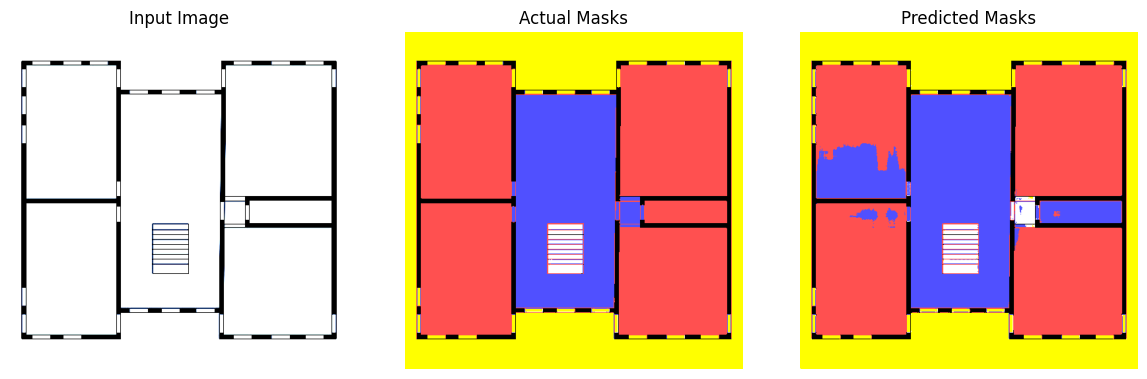

In [73]:
plot_segmentation(
    model=model, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='daft_seg_fig', 
    save_format='png', 
    close_img=False
)

## Save Predictions

In [74]:
# Model1 Saving
save_pred_masks(
    model=model,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

## History Graphs

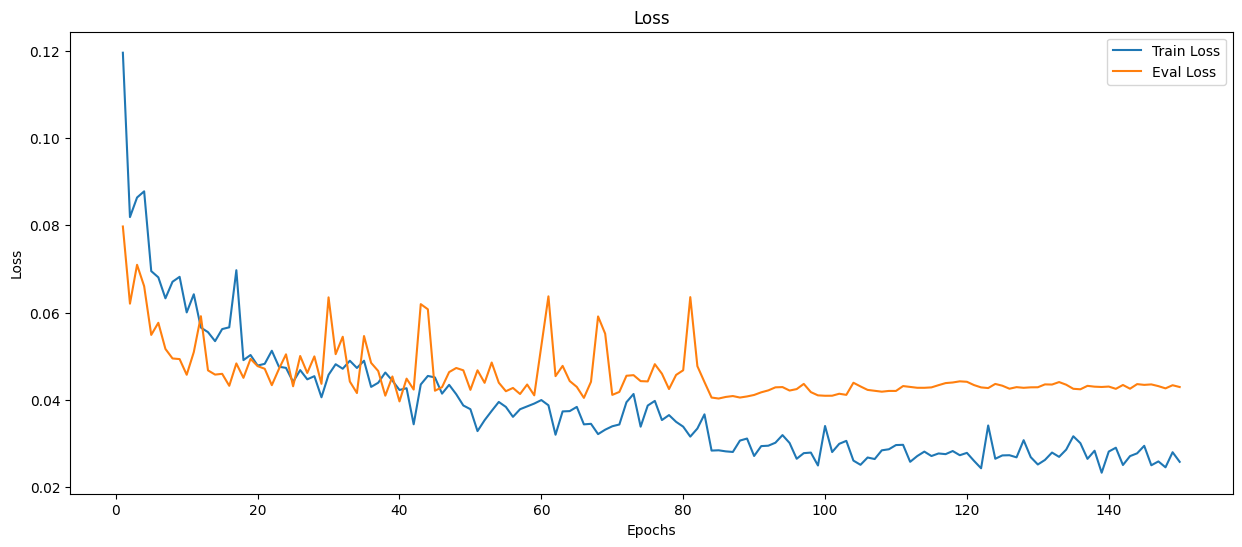

In [77]:
epoch_range = np.arange(1, hyperparameters['epochs']+1, 1, dtype=int)
plt.figure(figsize = (15,6))
plt.title("Loss")
plt.plot(epoch_range, history['train_loss'], label="Train Loss")
plt.plot(epoch_range, history['eval_loss'], label="Eval Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

loss_dir = os.path.join(hyperparameters['output_dir']['results'], 'loss_graph.png')
plt.savefig(loss_dir, format='png', bbox_inches='tight')
plt.show()


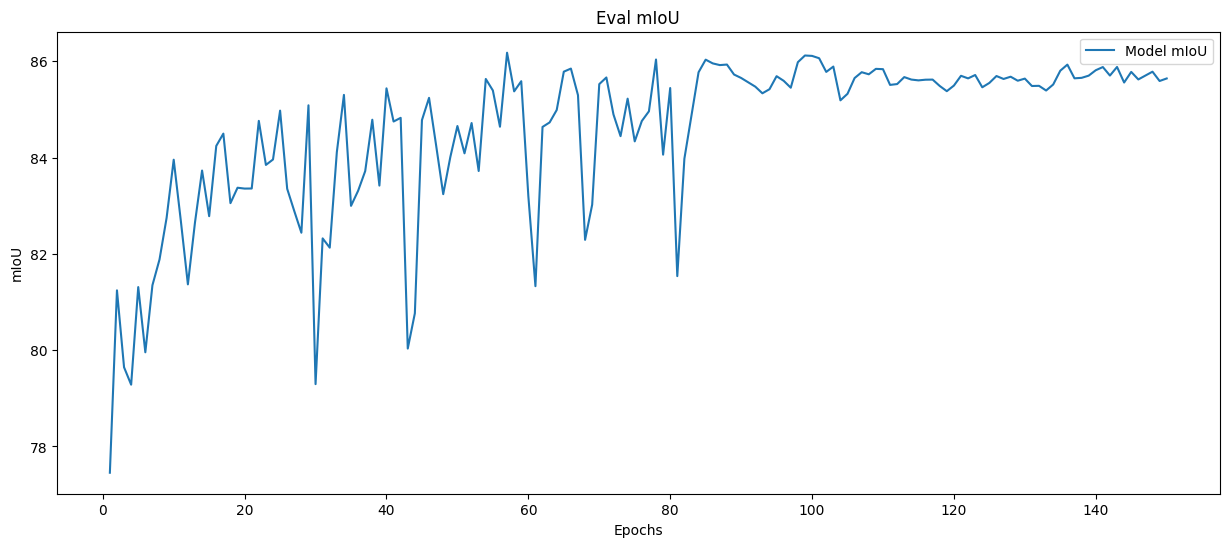

In [78]:
plt.figure(figsize = (15,6))
plt.title(f"Eval mIoU")
plt.plot(epoch_range, history['eval_miou'], label="Model mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend();
miou_dir = os.path.join(hyperparameters['output_dir']['results'], 'miou_graph.png')
plt.savefig(miou_dir, format='png', bbox_inches='tight')

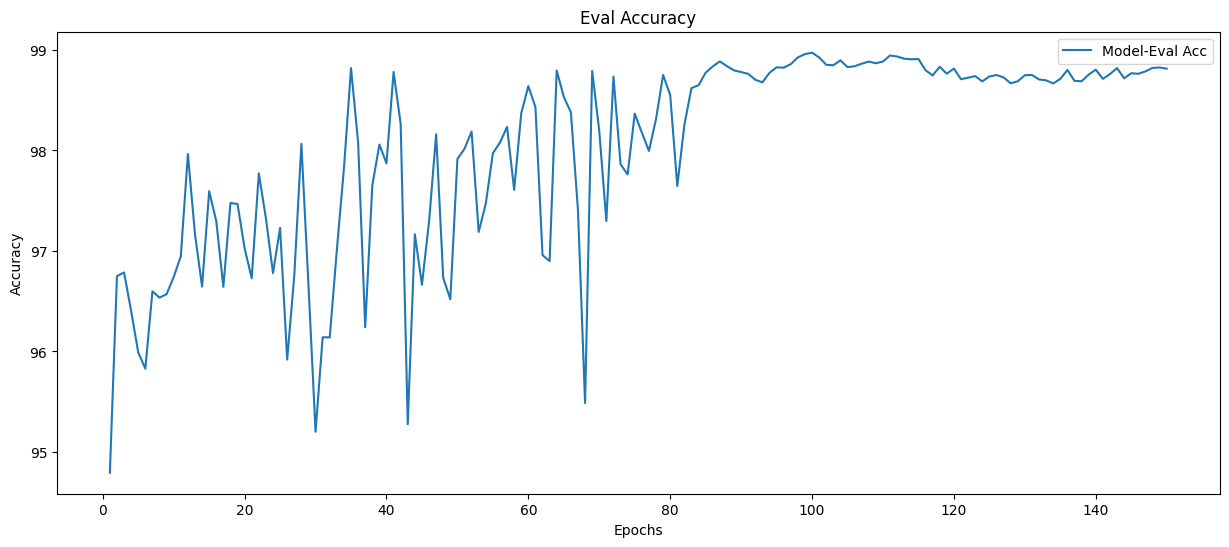

In [79]:
acc_tensor = torch.tensor(history['eval_acc'])
acc_tensor = acc_tensor.to('cpu')
acc_list = acc_tensor.tolist()

plt.figure(figsize = (15,6))
plt.title(f"Eval Accuracy")
plt.plot(epoch_range, acc_list, label="Model-Eval Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
acc_dir = os.path.join(hyperparameters['output_dir']['results'], 'accuracy_graph.png')
plt.savefig(acc_dir, format='png', bbox_inches='tight')

In [80]:
for param in model.parameters():
    param.requires_grad = True

In [81]:
save_model(
        model=model, 
        optimizer=optimizer, 
        root_folder=hyperparameters['checkpoints_dir'], 
        file_name='Daft_Segmentation_checkpointLast', 
        hyperparameter_dict=hyperparameters, 
        best_model=best_model, 
        last_epoch=hyperparameters['epochs']+1, 
        verbose=False)